In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
TICKER = 'AAPL'

In [2]:
df = pd.read_csv('./data/{}.csv'.format(TICKER))
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.100751,0.101189,0.100751,0.100751,469033600,0.0,0.0
1,1980-12-15,0.095933,0.095933,0.095495,0.095495,175884800,0.0,0.0
2,1980-12-16,0.088923,0.088923,0.088485,0.088485,105728000,0.0,0.0
3,1980-12-17,0.090676,0.091114,0.090676,0.090676,86441600,0.0,0.0
4,1980-12-18,0.093304,0.093742,0.093304,0.093304,73449600,0.0,0.0


In [3]:
df['Mean'] = df[['High', 'Low']].mean(axis=1)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Mean
0,1980-12-12,0.100751,0.101189,0.100751,0.100751,469033600,0.0,0.0,0.100970
1,1980-12-15,0.095933,0.095933,0.095495,0.095495,175884800,0.0,0.0,0.095714
2,1980-12-16,0.088923,0.088923,0.088485,0.088485,105728000,0.0,0.0,0.088704
3,1980-12-17,0.090676,0.091114,0.090676,0.090676,86441600,0.0,0.0,0.090895
4,1980-12-18,0.093304,0.093742,0.093304,0.093304,73449600,0.0,0.0,0.093523
...,...,...,...,...,...,...,...,...,...
10202,2021-06-01,125.080002,125.349998,123.940002,124.279999,67637100,0.0,0.0,124.645000
10203,2021-06-02,124.279999,125.239998,124.050003,125.059998,59278900,0.0,0.0,124.645000
10204,2021-06-03,124.680000,124.849998,123.129997,123.540001,76229200,0.0,0.0,123.989998
10205,2021-06-04,124.070000,126.160004,123.849998,125.889999,75087300,0.0,0.0,125.005001


<AxesSubplot:xlabel='Date'>

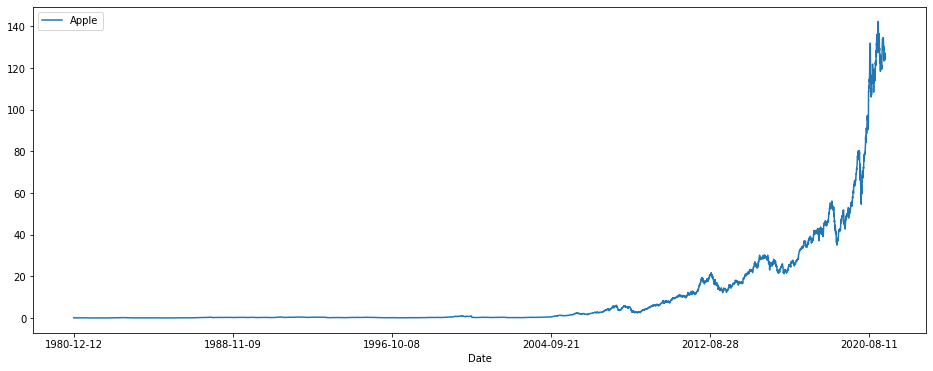

In [4]:
df.plot(x='Date', y='Mean', label='Apple', figsize=(16,6))

In [5]:
df_label = df[['Mean']]
sc = MinMaxScaler(feature_range = (0, 1))
df_label_scaled = sc.fit_transform(df_label)

df_train = df.loc[:9846, :]
df_test = df.loc[9846:, :]

In [6]:
df_train

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Mean
0,1980-12-12,0.100751,0.101189,0.100751,0.100751,469033600,0.0,0.0,0.100970
1,1980-12-15,0.095933,0.095933,0.095495,0.095495,175884800,0.0,0.0,0.095714
2,1980-12-16,0.088923,0.088923,0.088485,0.088485,105728000,0.0,0.0,0.088704
3,1980-12-17,0.090676,0.091114,0.090676,0.090676,86441600,0.0,0.0,0.090895
4,1980-12-18,0.093304,0.093742,0.093304,0.093304,73449600,0.0,0.0,0.093523
...,...,...,...,...,...,...,...,...,...
9842,2019-12-24,70.338354,70.387771,69.901043,70.234581,48478800,0.0,0.0,70.144407
9843,2019-12-26,70.370482,71.645364,70.340834,71.628067,93121200,0.0,0.0,70.993099
9844,2019-12-27,71.927010,72.631161,71.185800,71.600876,146266000,0.0,0.0,71.908481
9845,2019-12-30,71.516870,72.314908,70.469295,72.025833,144114400,0.0,0.0,71.392102


In [7]:
X_train = []
y_train = []
no_of_sample = len(df_label_scaled)

for i in range(60, no_of_sample):
    X_train.append(df_label_scaled[i-60:i, 0])
    y_train.append(df_label_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [9]:
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("mymodel.h5")

In [10]:
real_stock_price = df_test[['Mean']]

In [11]:
df_total = pd.concat((df_train['Mean'], df_test['Mean']), axis = 0)

inputs = df_total[len(df_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

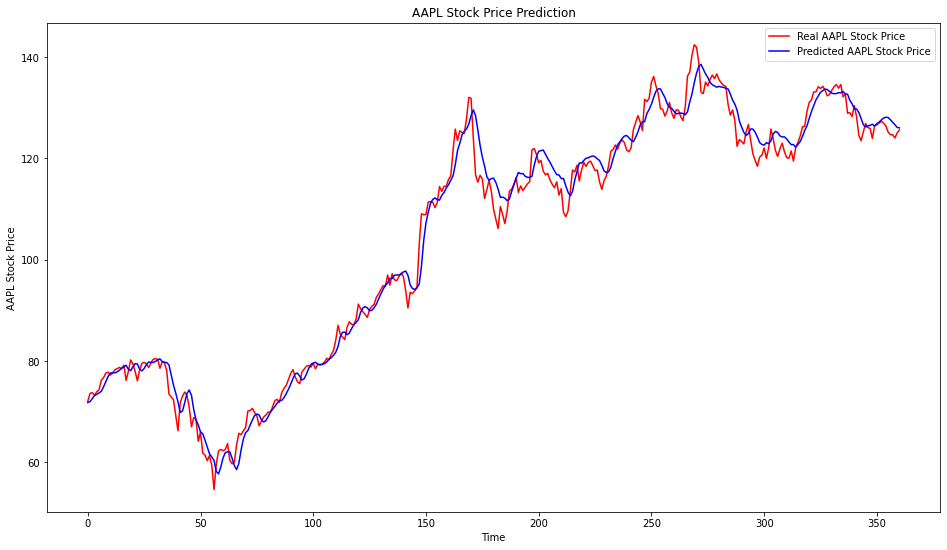

In [12]:
plt.figure(figsize=(16,9))
plt.plot(real_stock_price.reset_index(drop=True), color = 'red', label = 'Real {} Stock Price'.format(TICKER))
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted {} Stock Price'.format(TICKER))
plt.title('{} Stock Price Prediction'.format(TICKER))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(TICKER))
plt.legend()
plt.show()